Imports

In [1]:
import random 
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Load Dataset

In [2]:
chars = sorted(set(string.ascii_lowercase))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

with open('names.txt', 'r') as f:
    names = f.read().splitlines()

random.shuffle(names)
n_train = int(0.8*len(names))
n_dev = int(0.9*len(names))
trainset = names[:n_train]
devset = names[n_train:n_dev]
testset = names[n_dev:]
len(trainset), len(devset), len(devset)

(25626, 3203, 3203)

In [3]:
def prepare_data(names, cl):
    xs, ys = [], []
    for name in names:
        name = name + '.'
        context = [stoi['.']]*cl
        for ch in name:
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(xs), torch.tensor(ys)

def print_context(X, y):
    for context, label in zip(X,y):
        con_str = ''.join(itos[ix.item()] for ix in context)
        print(f'{con_str} --> {itos[label.item()]}')

context_length = 8
X_train, y_train = prepare_data(trainset, context_length)
X_dev, y_dev = prepare_data(devset, context_length)
X_test, y_test = prepare_data(testset, context_length)
print_context(X_train[:10], y_train[:10])

........ --> k
.......k --> a
......ka --> r
.....kar --> l
....karl --> i
...karli --> n
..karlin --> .
........ --> m
.......m --> i
......mi --> c


In [4]:
C = torch.randn(27, 10)
C[X_train[:4]].shape

torch.Size([4, 8, 10])

I implemented the Wavenet from the Lecture both with Dense Layers and 1D Convolutions (Cross-Correlations) in Pytorch.

In [35]:
class FlattenConsecutive(nn.Module):
    def __init__(self, n_consecutive=2):
        super().__init__()
        self.n_consecutive = n_consecutive
    def __call__(self, x):
        B, T, C = x.shape
        x = x.reshape(B, T//self.n_consecutive, self.n_consecutive*C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        return x

class BatchNorm1d_Permuted(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features)

    def __call__(self, x):
        return self.bn(x.permute((0, 2, 1))).permute((0, 2, 1))

class WaveNetDense(nn.Module):
    def __init__(self, vocab_size=27, emb_size=24, n_cons=2, n_hidden=128):
        super().__init__()
 
        self.model = nn.Sequential(
        nn.Embedding(vocab_size, emb_size),
        FlattenConsecutive(n_cons), nn.Linear(emb_size*n_cons, n_hidden, bias=False), BatchNorm1d_Permuted(n_hidden), nn.ReLU(),
        FlattenConsecutive(n_cons), nn.Linear(n_hidden*n_cons, n_hidden, bias=False), BatchNorm1d_Permuted(n_hidden), nn.ReLU(),
        FlattenConsecutive(n_cons), nn.Linear(n_hidden*n_cons, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.ReLU(),
        nn.Linear(n_hidden, vocab_size))

    def forward(self, x):
        return self.model(x)

class WaveNetConv(nn.Module):
    def __init__(self, vocab_size=27, emb_size=24, n_cons=2, channels=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.layer1 = nn.Sequential(nn.Conv1d(emb_size, channels, 2, stride=2, bias=False), nn.BatchNorm1d(channels), nn.Tanh())
        self.layer2 = nn.Sequential(nn.Conv1d(channels, channels, 2, stride=2, bias=False), nn.BatchNorm1d(channels), nn.Tanh())
        self.layer3 = nn.Sequential(nn.Conv1d(channels, channels, 2, stride=2, bias=False), nn.BatchNorm1d(channels), nn.Tanh())
        self.out_layer = nn.Linear(channels, vocab_size)

    def forward(self, x):
        embs = self.embedding(x).transpose(1,2)
        z = self.layer1(embs)
        z = self.layer2(z)
        z = self.layer3(z).squeeze()
        return self.out_layer(z)

wavenet_conv = WaveNetConv()

wavenet_dense = WaveNetDense()

In [36]:
def train_model(model, max_steps=200_000, batch_size=32, lr=0.1):
    lossi = []

    for i in range(max_steps):
        # forward 
        ixs = torch.randint(low=0, high=len(X_train), size=(batch_size,))
        Xb, yb = X_train[ixs], y_train[ixs]
        logits = model(Xb)
        loss = F.cross_entropy(logits, yb)

        # backward
        loss.backward()
        lr = 0.1 if i < 100_000 else 0.01 # lr decay

        for p in model.parameters():
            p.data += -lr * p.grad
            p.grad = None

        if i % 10_000 == 0:
            print(f"{i}/{max_steps}: {loss.item():.4f}")

        lossi.append(loss.log10().item())
    return lossi

lossi_conv = train_model(wavenet_conv)
lossi_dense = train_model(wavenet_dense)

0/200000: 3.2853
10000/200000: 1.9111
20000/200000: 2.3738
30000/200000: 2.0414
40000/200000: 2.2684
50000/200000: 1.8384
60000/200000: 1.5813
70000/200000: 1.8896
80000/200000: 2.0633
90000/200000: 1.5987
100000/200000: 2.1694
110000/200000: 1.5566
120000/200000: 1.9177
130000/200000: 1.7804
140000/200000: 1.8898
150000/200000: 1.9157
160000/200000: 2.1189
170000/200000: 2.0738
180000/200000: 1.2539
190000/200000: 2.3081
0/200000: 3.4489
10000/200000: 2.1366
20000/200000: 1.8629
30000/200000: 2.1145
40000/200000: 1.6931
50000/200000: 1.8872
60000/200000: 2.0542
70000/200000: 2.5242
80000/200000: 2.1541
90000/200000: 1.8942
100000/200000: 1.9927
110000/200000: 1.8703
120000/200000: 1.7763
130000/200000: 2.0194
140000/200000: 1.9057
150000/200000: 1.6324
160000/200000: 2.0033
170000/200000: 2.0597
180000/200000: 1.4782
190000/200000: 2.0125


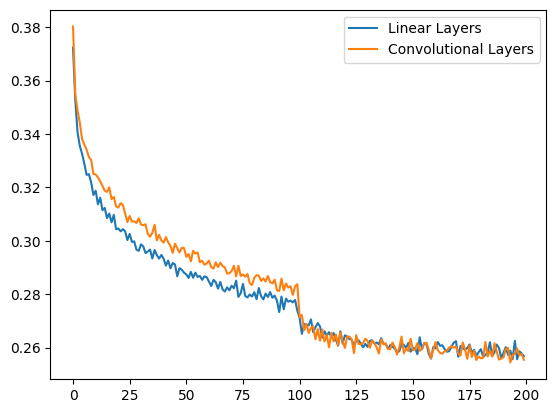

In [38]:
plt.plot(torch.tensor(lossi_dense).view(-1, 1000).mean(1), label="Linear Layers")
plt.plot(torch.tensor(lossi_conv).view(-1, 1000).mean(1), label="Convolutional Layers")
plt.legend();

In [39]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(model, split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_dev, y_dev),
    'test': (X_test, y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

print("----Result with Linear Layers----")
split_loss(wavenet_dense, 'train')
split_loss(wavenet_dense, 'val')
print("----Result with Convolutions----")
split_loss(wavenet_conv, 'train')
split_loss(wavenet_conv, 'val')

----Result with Linear Layers----
train 1.7714321613311768
val 1.9791423082351685
----Result with Convolutions----
train 1.7861332893371582
val 1.977806806564331
